In [37]:
# Import helps
from src.helpers import *
from src.plots import *

# Import base
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split

# Feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

# tensorflow
import tensorflow as tf

pd.options.display.max_rows = 999

# Set seeds for reproducibility
set_seeds()

In [38]:
# class weight function
def cwts(y):
    c0, c1 = np.bincount(y)
    w0=(1/c0)*(len(y))/2 
    w1=(1/c1)*(len(y))/2 
    return {0: w0, 1: w1}

In [39]:
weights = {0: 0.5942162615255658, 1: 3.15346975088968}

In [40]:
tf.keras.backend.clear_session()

In [41]:
# Reload the saved scaled data
X_train = pd.read_csv('data/train/scaled_X_train.csv', parse_dates=True, index_col='unix')
y_train = pd.read_csv('data/train/y_train.csv', parse_dates=True, index_col='unix')
X_test = pd.read_csv('data/test/scaled_X_test.csv', parse_dates=True, index_col='unix')
y_test = pd.read_csv('data/test/y_test.csv', parse_dates=True, index_col='unix')
X_val = pd.read_csv('data/val/scaled_X_val.csv', parse_dates=True, index_col='unix')
y_val = pd.read_csv('data/val/y_val.csv', parse_dates=True, index_col='unix')

In [42]:
y = pd.concat([y_train, y_val, y_test])
y.values.flatten()
weights = cwts(y.values.flatten())

In [43]:
# Reshape the data into the correct format
seqlen = 1
featurelen = X_train.shape[-1]
train_tensors = tf.keras.utils.timeseries_dataset_from_array(X_train, y_train, seqlen)
val_tensors = tf.keras.utils.timeseries_dataset_from_array(X_val, y_val, seqlen)
test_tensors = tf.keras.utils.timeseries_dataset_from_array(X_test, y_test, seqlen)

In [44]:
# Baseline model
inputs = tf.keras.Input(shape=(seqlen, featurelen))
x = tf.keras.layers.LSTM(36)(inputs)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 366)]          0         
                                                                 
 lstm (LSTM)                 (None, 36)                58032     
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 58069 (226.83 KB)
Trainable params: 58069 (226.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5)]

model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(x=train_tensors, epochs=100, validation_data=val_tensors,
                    class_weight=weights, callbacks=callbacks)

Epoch 1/100
94/94 [==============================] - 2s 7ms/step - loss: 0.7384 - accuracy: 0.4070 - precision: 0.2516 - recall: 0.8828 - val_loss: 0.5969 - val_accuracy: 0.8007 - val_precision: 0.2517 - val_recall: 0.4302
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6957 - accuracy: 0.5177 - precision: 0.2895 - recall: 0.8461 - val_loss: 0.5508 - val_accuracy: 0.8144 - val_precision: 0.2817 - val_recall: 0.4651
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.5696 - precision: 0.3122 - recall: 0.8241 - val_loss: 0.5475 - val_accuracy: 0.7951 - val_precision: 0.2732 - val_recall: 0.5419
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.5898 - precision: 0.3218 - recall: 0.8105 - val_loss: 0.5586 - val_accuracy: 0.7701 - val_precision: 0.2601 - val_recall: 0.6140
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 0.6630 - accuracy: 0.6026 - precisi

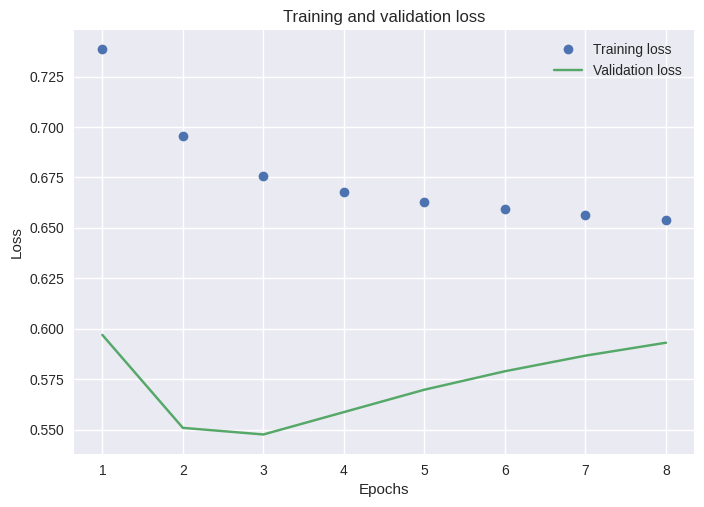

In [47]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plot_metrics(loss_values, val_loss_values, 'loss')

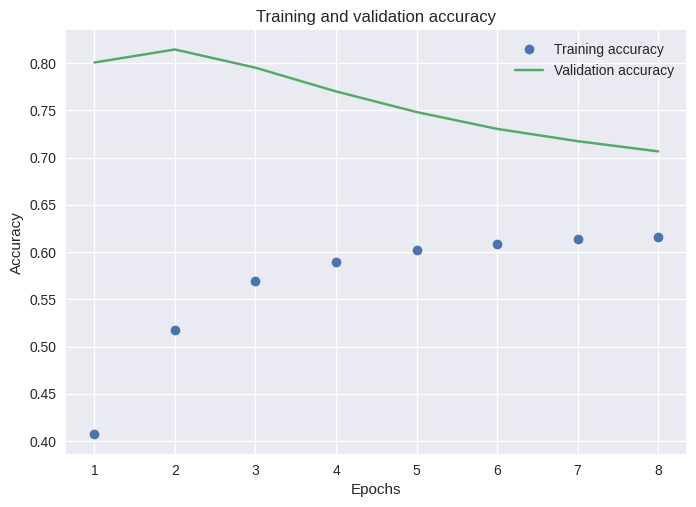

In [48]:
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
plot_metrics(accuracy_values, val_accuracy_values, 'accuracy')

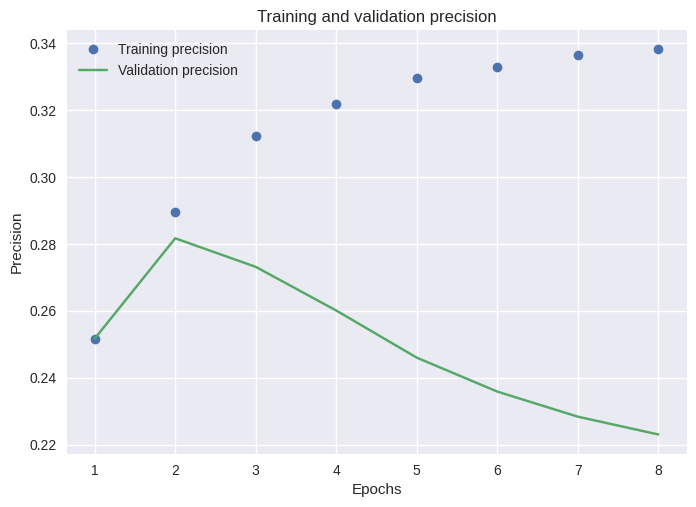

In [49]:
precision_values = history_dict['precision']
val_precision_values = history_dict['val_precision']
plot_metrics(precision_values, val_precision_values, 'precision')

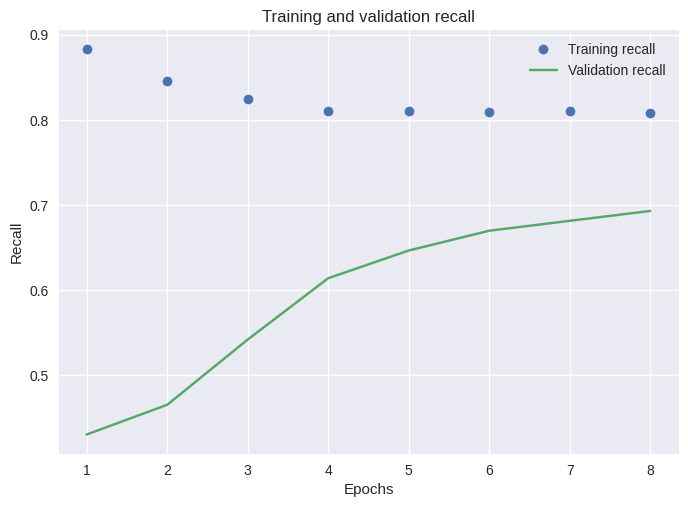

In [50]:
recall_values = history_dict['recall']
val_recall_values = history_dict['val_recall']
plot_metrics(recall_values, val_recall_values, 'recall')

In [51]:
y_pred = np.where(model.predict(test_tensors) > 0.5, 1, 0)

42/42 [==============================] - 0s 1ms/step


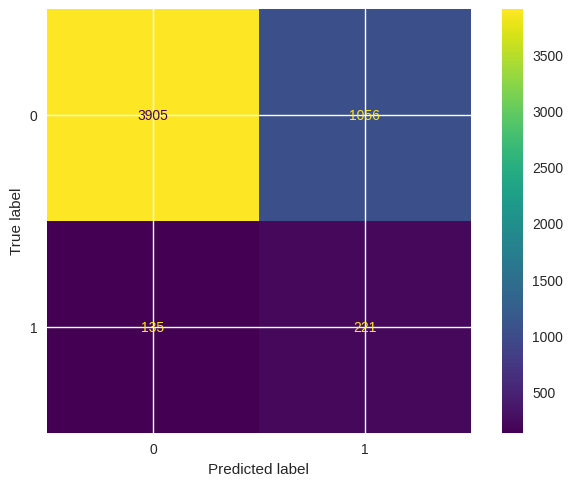

In [52]:
# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report

cm = confusion_matrix(y_test.values, y_pred.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

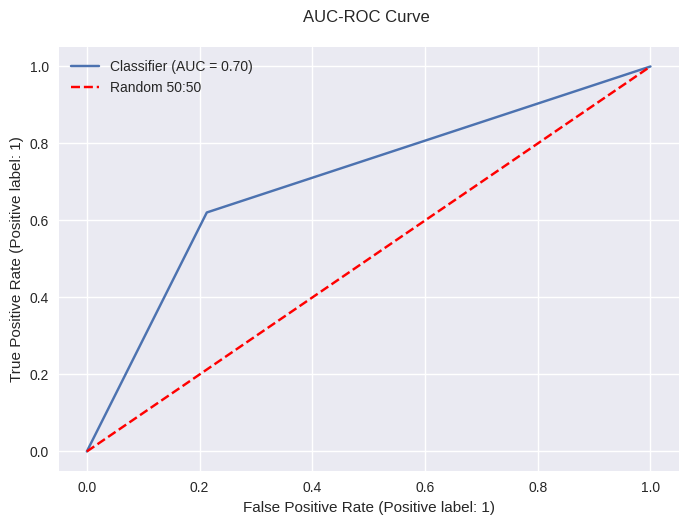

In [53]:
RocCurveDisplay.from_predictions(y_test, y_pred)
plt.title("AUC-ROC Curve \n")
plt.plot([0, 1], [0, 1], linestyle="--", label='Random 50:50', color='r')
plt.legend()
plt.show()

In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      4961
           1       0.17      0.62      0.27       356

    accuracy                           0.78      5317
   macro avg       0.57      0.70      0.57      5317
weighted avg       0.91      0.78      0.83      5317

